In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('properties_post_feature_selection_2.csv')

In [3]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sohna road road,6.25,3.0,3.0,0,Moderately Old,9000.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 103,1.15,2.0,2.0,3,Relatively New,1080.0,0.0,0.0,2.0,High,Mid Floor
2,flat,sector 102,1.45,3.0,3.0,3,Relatively New,1300.0,1.0,0.0,0.0,Low,Mid Floor
3,flat,sector 85,1.05,2.0,2.0,3+,Relatively New,1512.0,0.0,1.0,0.0,Medium,Mid Floor
4,house,sector 83,1.70,3.0,3.0,3+,New Property,2160.0,1.0,0.0,0.0,Low,Mid Floor


In [4]:
df=df.drop(3550)
df=df.drop(1811)

In [5]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
2.0    1017
1.0     186
Name: count, dtype: int64

In [6]:
df.groupby(['furnishing_type']).agg({'price':['min','max','mean'],'built_up_area':['min','max','mean']})

price                 built_up_area                      
                  min   max      mean           min      max         mean
furnishing_type                                                          
0.0              0.07  25.0  1.985913          33.0  12222.0  1712.013908
1.0              0.22  31.5  3.721237          60.0   9500.0  2286.818548
2.0              0.22  27.5  3.262498          50.0  11286.0  2131.531170

In [7]:
# 0 -> unfurnished
# 2 -> semifurnished
# 1 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',2.0:'semifurnished',1.0:'furnished'})

In [8]:
df['furnishing_type'].value_counts()

furnishing_type
unfurnished      2349
semifurnished    1017
furnished         186
Name: count, dtype: int64

In [9]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sohna road road,6.25,3.0,3.0,0,Moderately Old,9000.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 103,1.15,2.0,2.0,3,Relatively New,1080.0,0.0,0.0,semifurnished,High,Mid Floor
2,flat,sector 102,1.45,3.0,3.0,3,Relatively New,1300.0,1.0,0.0,unfurnished,Low,Mid Floor
3,flat,sector 85,1.05,2.0,2.0,3+,Relatively New,1512.0,0.0,1.0,unfurnished,Medium,Mid Floor
4,house,sector 83,1.70,3.0,3.0,3+,New Property,2160.0,1.0,0.0,unfurnished,Low,Mid Floor


In [10]:
X = df.drop(columns=['price'])
y = df['price']

In [11]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

In [12]:
# using different techniques for converting categorical features into numerical - ordinal coding, one hot coding, target encoding
# will select the best method according to the best r2 score

## Ordinal Encoding

In [23]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [24]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ], 
    remainder='passthrough'
)

In [25]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['bedRoom', 'bathroom', 'built_up_area',
                                  'servant room', 'store room']),
                                ('cat', OrdinalEncoder(),
                                 ['property_type', 'sector', 'balcony',
                                  'agePossession', 'furnishing_type',
                                  'luxury_category', 'floor_category'])])

In [26]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [27]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [28]:
scores.mean(),scores.std()

(0.7354609694920144, 0.025774910592173326)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=0)

In [30]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [31]:
y_pred = pipeline.predict(X_test)

In [32]:
y_pred = np.expm1(y_pred)

In [33]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.9812235946643183

In [34]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=0)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output

In [35]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [36]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [37]:
model_output

[['linear_reg', 0.7354609694920144, 0.9812235946643183],
 ['svr', 0.7600500359013339, 0.8185147025735151],
 ['ridge', 0.735467418836192, 0.9810273517517252],
 ['LASSO', 0.05584704359722818, 1.5528445689941066],
 ['decision tree', 0.7792983969455557, 0.738460467115715],
 ['random forest', 0.8800210368159739, 0.5266131586266349],
 ['extra trees', 0.868544138149774, 0.5706542368936577],
 ['gradient boosting', 0.8744611904269114, 0.5617532302838001],
 ['adaboost', 0.7576256175676208, 0.8796313199912619],
 ['xgboost', 0.8938239984191126, 0.5278002761017254]]

In [38]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [39]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.880021,0.526613
9,xgboost,0.893824,0.527800
7,gradient boosting,0.874461,0.561753
6,extra trees,0.868544,0.570654
4,decision tree,0.779298,0.738460
1,svr,0.760050,0.818515
8,adaboost,0.757626,0.879631
2,ridge,0.735467,0.981027
0,linear_reg,0.735461,0.981224
3,LASSO,0.055847,1.552845


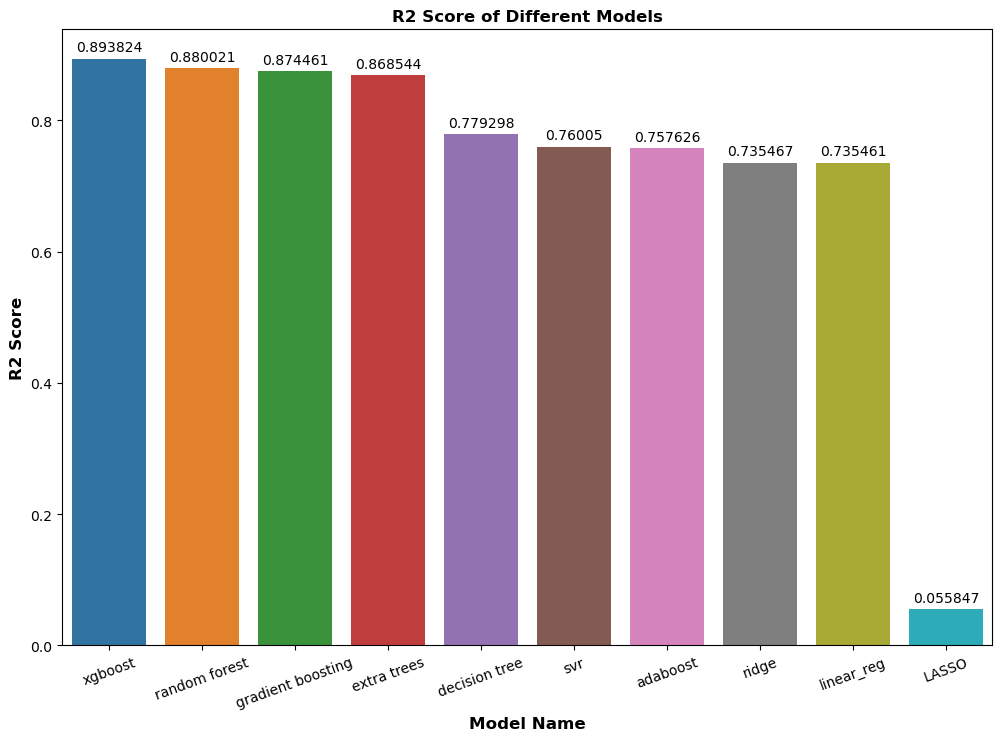

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
ax = sns.barplot(x='name', y='r2',
                  data=model_df.sort_values(['r2'],ascending=False),
                 errwidth=0)
plt.xticks(rotation=20)
plt.title("R2 Score of Different Models", fontweight='bold',size=12)
plt.xlabel("Model Name", fontweight='bold',size=12)
plt.ylabel("R2 Score", fontweight='bold',size=12)
for i in ax.containers:
    ax.bar_label(i,padding=3)
plt.show() 

## OneHotEncoding

In [41]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ], 
    remainder='passthrough'
)

In [42]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [43]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [44]:
scores.mean()

0.8536814433161073

In [45]:
scores.std()

0.01945545327774775

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=0)

In [47]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [48]:
y_pred = pipeline.predict(X_test)

In [49]:
y_pred = np.expm1(y_pred)

In [50]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6909923904785414

In [51]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [52]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [53]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [54]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [55]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.891866,0.514288
9,xgboost,0.896834,0.540108
5,random forest,0.889443,0.553715
7,gradient boosting,0.873835,0.601703
0,linear_reg,0.853681,0.666281
2,ridge,0.854039,0.672152
4,decision tree,0.805810,0.704788
8,adaboost,0.754174,0.895916
1,svr,0.763707,0.908407
3,LASSO,0.055847,1.566611


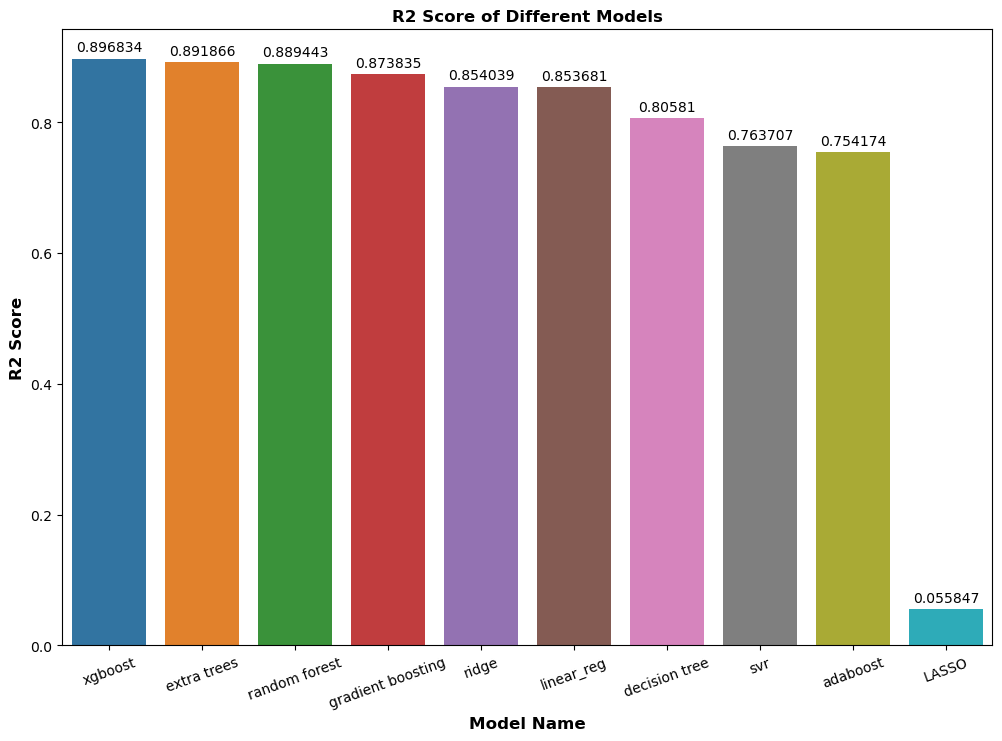

In [56]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x='name', y='r2',
                  data=model_df.sort_values(['r2'],ascending=False),
                 errwidth=0)
plt.xticks(rotation=20)
plt.title("R2 Score of Different Models", fontweight='bold',size=12)
plt.xlabel("Model Name", fontweight='bold',size=12)
plt.ylabel("R2 Score", fontweight='bold',size=12)
for i in ax.containers:
    ax.bar_label(i,padding=3)
plt.show() 

## Target Encoder

In [57]:
import category_encoders as ce

columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [58]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [59]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [60]:
scores.mean(),scores.std()

(0.825224198193229, 0.020164889573665107)

In [61]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output

In [62]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [63]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [64]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [65]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.899764,0.490590
9,xgboost,0.897217,0.494816
6,extra trees,0.900240,0.505126
7,gradient boosting,0.887534,0.574864
4,decision tree,0.817376,0.629468
0,linear_reg,0.825224,0.748356
2,ridge,0.825248,0.748685
8,adaboost,0.819912,0.762058
1,svr,0.776952,0.892042
3,LASSO,0.055847,1.566611


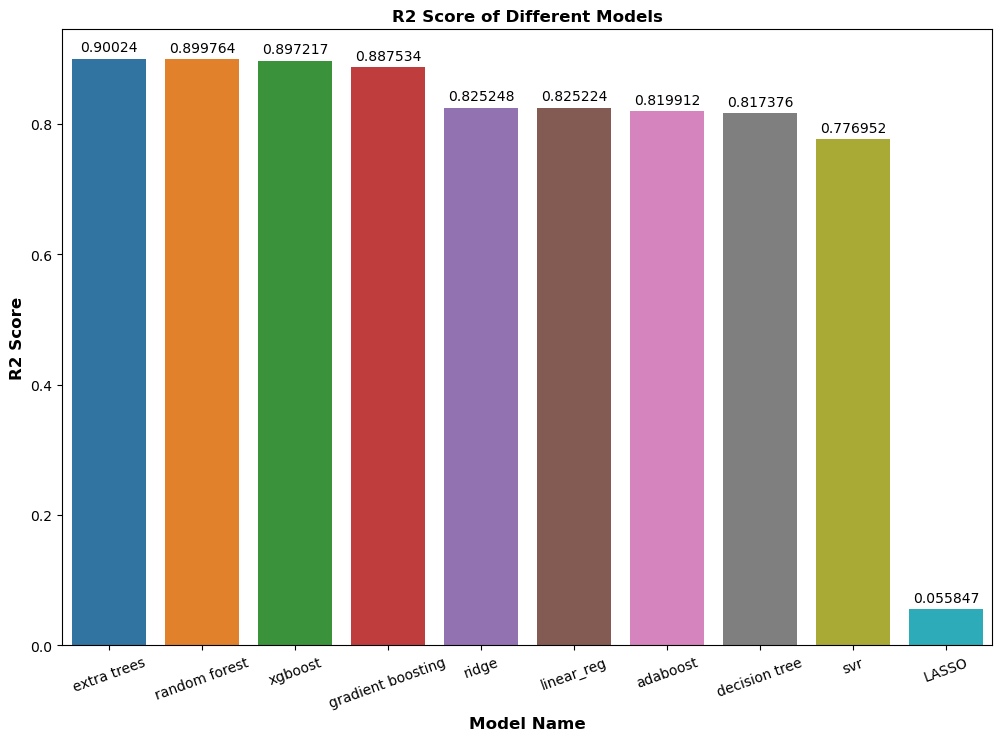

<Figure size 640x480 with 0 Axes>

In [66]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x='name', y='r2',
                  data=model_df.sort_values(['r2'],ascending=False),
                 errwidth=0)
plt.xticks(rotation=20)
plt.title("R2 Score of Different Models", fontweight='bold',size=12)
plt.xlabel("Model Name", fontweight='bold',size=12)
plt.ylabel("R2 Score", fontweight='bold',size=12)
for i in ax.containers:
    ax.bar_label(i,padding=3)
plt.show() 
plt.savefig('visual3.png')

## Hyperparameter Tuning

In [736]:
from sklearn.model_selection import RandomizedSearchCV

In [737]:
params_rf={"regressor__criterion":['absolute_error', 'squared_error', 'poisson', 'friedman_mse'],
          "regressor__max_depth":[5,8,11,13,15],
          "regressor__min_samples_split":[10,1520,30,40],
          "regressor__min_samples_leaf":[1,2,5,20,10],
          "regressor__n_estimators":[30,40,50,100,150,200,300],
          "regressor__bootstrap":[True],
          "regressor__max_features":["sqrt","log2"],
          "regressor__max_samples":[.5,.6,.7,.75,.8]}

In [738]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [739]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [740]:
search = RandomizedSearchCV(pipeline, params_rf, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [741]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['bedRoom',
                                                                                'bathroom',
                                                                                'built_up_area',
                                                                                'servant '
                                                                                'room',
                                                                                'store '
                                                                                'room']),
                                                                              ('cat',
                                                                               OrdinalEncoder(),
                                                                               ['property_type',
                                                                                'sector',
                                                                                'balcony',
                                                                                'agePossession',
                                                                                'furnishing_t...
                                        'regressor__criterion': ['absolute_error',
                                                                 'squared_error',
                                                                 'poisson',
                                                                 'friedman_mse'],
                                        'regressor__max_depth': [5, 8, 11, 13,
                                                                 15],
                                        'regressor__max_features': ['sqrt',
                                                                    'log2'],
                                        'regressor__max_samples': [0.5, 0.6,
                                                                   0.7, 0.75,
                                                                   0.8],
                                        'regressor__min_samples_leaf': [1, 2, 5,
                                                                        20,
                                                                        10],
                                        'regressor__min_samples_split': [10,
                                                                         1520,
                                                                         30,
                                                                         40],
                                        'regressor__n_estimators': [30, 40, 50,
                                                                    100, 150,
                                                                    200, 300]},
                   scoring='r2', verbose=4)

In [742]:
search.best_params_

{'regressor__n_estimators': 100,
 'regressor__min_samples_split': 10,
 'regressor__min_samples_leaf': 1,
 'regressor__max_samples': 0.7,
 'regressor__max_features': 'sqrt',
 'regressor__max_depth': 8,
 'regressor__criterion': 'friedman_mse',
 'regressor__bootstrap': True}

In [743]:
search.best_score_

0.8793194602662128

In [744]:
# there is no improvement in the model performance using hyperparameter tuning hence we will build the model with the default parameters

## Exporting the model

In [59]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [60]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [61]:
pipeline.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor', RandomForestRegressor(n_estimators=500))])

In [62]:
import bz2file as bz2
import pickle

In [65]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [67]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [64]:
with bz2.BZ2File('pipeline1.pbz2', 'w') as f:
    pickle.dump(pipeline, f)

In [549]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sohna road road,3.0,3.0,0,Moderately Old,9000.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 103,2.0,2.0,3,Relatively New,1080.0,0.0,0.0,semifurnished,High,Mid Floor
2,flat,sector 102,3.0,3.0,3,Relatively New,1300.0,1.0,0.0,unfurnished,Low,Mid Floor
3,flat,sector 85,2.0,2.0,3+,Relatively New,1512.0,0.0,1.0,unfurnished,Medium,Mid Floor
4,house,sector 83,3.0,3.0,3+,New Property,2160.0,1.0,0.0,unfurnished,Low,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3548,flat,sector 65,3.0,3.0,3,Relatively New,3043.0,1.0,0.0,unfurnished,Medium,High Floor
3549,flat,sector 104,3.0,4.0,3+,Moderately Old,2217.0,1.0,0.0,unfurnished,Medium,Mid Floor
3551,flat,sector 103,2.0,3.0,3,Relatively New,1257.0,1.0,0.0,semifurnished,Medium,Low Floor
3552,house,sector 43,4.0,4.0,3+,Moderately Old,540.0,0.0,0.0,furnished,Low,Mid Floor


## Trying out the predictions

In [550]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [551]:
X.iloc[0].values

array(['house', 'sohna road road', 3.0, 3.0, '0', 'Moderately Old',
       9000.0, 0.0, 0.0, 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [560]:
data = [['flat', 'sector 102', 2, 3, '3+', 'Old Property', 1750, 0, 0, 'furnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 102,2,3,3+,Old Property,1750,0,0,furnished,Low,Low Floor


In [561]:
np.expm1(pipeline.predict(one_df))

array([1.64279222])